# 库导入

In [18]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.losses import mse

tf.compat.v1.disable_eager_execution()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# 数据导入

In [19]:
indexx = 1

Intrain = np.load('ComIntrain%s.npy'%indexx)
Outtrain = np.load('EnOuttrain%s.npy'%indexx)

InLtrain = np.load('EnIntrain%s.npy'%indexx)
OutLtrain = np.load('EnOutLtrain%s.npy'%indexx)

Intest = np.load('ComIntest%s.npy'%indexx)
Outtest = np.load('EnOuttest%s.npy'%indexx)

InLtest = np.load('EnIntest%s.npy'%indexx)
OutLtest = np.load('EnOutLtest%s.npy'%indexx)


print(Intrain.shape,Outtrain.shape,InLtrain.shape, OutLtrain.shape, Outtest.shape, OutLtest.shape)

(4353, 10, 5) (4353, 10, 2) (4353, 10, 2) (4353, 3) (1110, 10, 2) (1110, 3)


# 参数设置

In [20]:
# 基本参数
batch_size = 60
epochs = 25
latent_dim = 72  # LSTM 的单元个数
encoder_length = InLtrain.shape[1]
decoder_length = Outtrain.shape[1]
num_encoder_tokens = InLtrain.shape[2]
num_decoder_tokens = Outtrain.shape[2]

# 采样

In [21]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# 损失函数

In [22]:
def VAE_loss(y_true, y_predicted):
    reconstruction_loss = mse(y_true, y_predicted)
    reconstruction_loss *= num_encoder_tokens
    return K.mean(reconstruction_loss)


def KL(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= - 0.5
    return K.mean(kl_loss)

# 编码解码器

In [23]:
# 定义编码器的输入
# encoder_inputs (None, num_encoder_tokens), None表示可以处理任意长度的序列
encoder_inputs = Input(shape=(encoder_length, num_encoder_tokens))

# 编码器，要求其返回状态
encoder = LSTM(latent_dim, return_state=True)

# 调用编码器，得到编码器的输出，以及状态信息 state_h 和 state_c
encoder_outpus, state_h, state_c = encoder(encoder_inputs)

z_mean1 = Dense(8, name='z_mean1')(encoder_outpus)
z_mean = Dense(num_decoder_tokens, name='z_mean2')(z_mean1)
z_log_var1 = Dense(8, name='z_log_var1')(encoder_outpus)
z_log_var = Dense(num_encoder_tokens, name='z_log_var2')(z_log_var1)

# 编码器的状态
encoder_state = [state_h, state_c]

# 采样
z = Lambda(sampling, name='z')([z_mean, z_log_var])
z = RepeatVector(encoder_length)(z)

# 定义解码器的输入
# None表示可以处理任意长度的序列

# 接下来建立解码器，解码器将返回整个输出序列并且返回其中间状态
# decoder_lstm = LSTM(latent_dim, return_sequences=True)
dencoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True), merge_mode='concat')
# 将编码器输出的状态作为初始解码器的初始状态
decoder_outputs = decoder_lstm(z, initial_state=encoder_state)

# 添加全连接层
decoder_dense1 = Dense(8, activation='relu')
decoder_dense2 = Dense(5, activation='relu')
decoder_dense3 = Dense(num_decoder_tokens, activation='relu')
decoder_outputs = decoder_dense3(
    decoder_dense2(decoder_dense1(decoder_outputs)))

# 定义整个模型
model = Model(encoder_inputs, decoder_outputs)

# 编译模型

model.add_loss(KL(z_mean, z_log_var))
model.compile(loss=VAE_loss, optimizer='adam')

print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 72), (None,  21600       input_3[0][0]                    
__________________________________________________________________________________________________
z_mean1 (Dense)                 (None, 8)            584         lstm_3[0][0]                     
__________________________________________________________________________________________________
z_log_var1 (Dense)              (None, 8)            584         lstm_3[0][0]                     
_______________________________________________________________________________________

# 模型训练与结果分析

In [24]:
History = model.fit(InLtrain,Outtrain,epochs=epochs,batch_size=batch_size,validation_data=(InLtest,Outtest))

Train on 4353 samples, validate on 1110 samples
Epoch 1/30
4353/4353 [==============================] - 1s 296us/sample - loss: 0.1429 - val_loss: 0.0798
Epoch 2/30
4353/4353 [==============================] - 1s 234us/sample - loss: 0.0765 - val_loss: 0.0595
Epoch 3/30
4353/4353 [==============================] - 1s 241us/sample - loss: 0.0519 - val_loss: 0.0474
Epoch 4/30
4353/4353 [==============================] - 1s 237us/sample - loss: 0.0423 - val_loss: 0.0398
Epoch 5/30
4353/4353 [==============================] - 1s 234us/sample - loss: 0.0351 - val_loss: 0.0353
Epoch 6/30
4353/4353 [==============================] - 1s 239us/sample - loss: 0.0320 - val_loss: 0.0344
Epoch 7/30
4353/4353 [==============================] - 1s 234us/sample - loss: 0.0308 - val_loss: 0.0329
Epoch 8/30
4353/4353 [==============================] - 1s 237us/sample - loss: 0.0291 - val_loss: 0.0316
Epoch 9/30
4353/4353 [==============================] - 1s 235us/sample - loss: 0.0277 - val_loss: 0.029

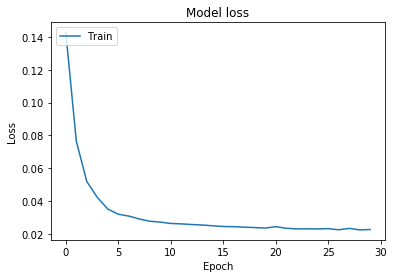

In [25]:
# 绘制训练 & 验证的损失值
plt.plot(History.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [26]:
score = model.evaluate(InLtest, Outtest)
print('Loss:', score)

Loss: 0.023670306701112438


In [27]:
pred = model.predict(InLtest)
pred

array([[[0.42436644, 0.42473093],
        [0.4258107 , 0.44734043],
        [0.42526922, 0.47473583],
        ...,
        [0.4107399 , 0.60803676],
        [0.40585926, 0.63132876],
        [0.40180662, 0.653785  ]],

       [[0.22005449, 0.55329096],
        [0.2191627 , 0.5977689 ],
        [0.21206464, 0.647175  ],
        ...,
        [0.23195004, 0.7944394 ],
        [0.2420936 , 0.783577  ],
        [0.2532073 , 0.7502532 ]],

       [[0.05835769, 0.6448543 ],
        [0.0616805 , 0.68710923],
        [0.06361169, 0.72898304],
        ...,
        [0.12982638, 0.78455335],
        [0.18176927, 0.6971829 ],
        [0.23259276, 0.5957357 ]],

       ...,

       [[0.3360662 , 0.43963686],
        [0.3291427 , 0.47260582],
        [0.32002524, 0.51054865],
        ...,
        [0.31932703, 0.6609957 ],
        [0.32179016, 0.6820658 ],
        [0.31453222, 0.70413816]],

       [[0.10090079, 0.23136397],
        [0.0420583 , 0.26814082],
        [0.03493262, 0.3442387 ],
        .

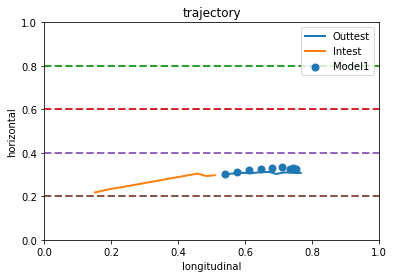

In [28]:
i = 56

apred = pred[i].swapaxes(0, 1)

aIntest = Intest[i].swapaxes(0, 1)
aOuttest = Outtest[i].swapaxes(0, 1)
# print(aIntest)

plt.plot(aOuttest[1], aOuttest[0], lw=2, label="Outtest")
plt.scatter(apred[1], apred[0], lw=2, label="Model1")
plt.plot(aIntest[1], aIntest[0], lw=2, label="Intest")

plt.plot(np.linspace(0, 1, 2), [0.8, 0.8], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.6, 0.6], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.4, 0.4], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.2, 0.2], lw=2, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('trajectory')
plt.ylabel('horizontal')
plt.xlabel('longitudinal')
plt.legend()
plt.show()